# MPAS Ocean visualization

MPAS Ocean visualization notebook

***

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import sys
import yaml
from scipy import signal
from itertools import groupby
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from tqdm import tqdm

# Import modules from path
sys.path.append('../modules/')
import postprocesstools as pptools
import transecttools as trtools
import watermasstools as wmttools

plt.rcParams.update({'font.size': 14, 'axes.titlesize': 'medium'})

***

### LR and HR postprocessing code

Requested variables and parameters

In [2]:
# 2D variable names
varNames2D = [
    'evaporationFlux',
    'rainFlux',
    'snowFlux',
    'riverRunoffFlux',
    'iceRunoffFlux',
    'seaIceFreshWaterFlux',
    'seaIceSalinityFlux',
    'salinitySurfaceRestoringTendency',
]

# 3D variable names
varNames3D = [
    'activeTracers_temperature',
    'activeTracers_salinity',
    'potentialDensity',
    'velocityZonal',
    'velocityMeridional',
]

# Transect variable names
varNamesTransect = [
    'potentialDensity',
    'layerThickness',
    'normalVelocity',
]

# Bounding box
bbox = [-100, 20, 40, 80]

# Time index
startyear = 1947
years, months = np.arange(1, 11), np.arange(1, 13)
timeindex = [datetime(startyear + year, month, 1) for year in years for month in months]
timeindex = pd.Index(timeindex, name='time')

# Avg depth index
depthindex = pd.Index([0, 20, 100, 500, 1000], name='depth')

# Initialize variables storage
datasets = {}

Get mesh variables, subdomain, and remapping params

In [5]:
meshName = 'LR'
datasets[meshName] = {}

# Get paths
with open(f'../yaml/paths_{meshName}.yaml') as f:
    paths = yaml.safe_load(f)
    
# Results prefix
prefix = paths['results']['1947-1957'] + '/' + paths['prefix']

# Load coords
coords, transectMasks, subdomain = pptools.load_coords(meshName)
transectLen = max([len(transectMask['edges']) for transectMask in transectMasks.values()])

# Remapping variables
remapvars = pptools.build_remapper(paths['meshfile'], bbox=bbox)

# Depth average indices
zindexes = [abs(coords['refBottomDepth'] - depth).argmin() + 1 for depth in depthindex]
zmax = max(zindexes)

# Initialize dicts and lists
data2D = {varName: [] for varName in varNames2D + varNames3D}
dataTransect = {varName: [] for varName in varNamesTransect}
wmt1D, wmt2D = [], []

# Sigmabin kwargs
sigma_kwargs = {'sigmarange': [27, 28.2], 'binsize': 0.01}

Load model variable fields

In [6]:
# Load variables
for year in years:
    for month in tqdm(months, desc=f'Processing year {year}'):
        f = f'{prefix}.{year:04d}-{month:02d}-01.nc'
        with xr.open_dataset(f) as ds:
            
            # Get 2D fields
            for varName in varNames2D:
                data = ds['timeMonthly_avg_' + varName][0, :].values[subdomain]
                data2D[varName].append(data)
            for varName in varNames3D:
                data = ds['timeMonthly_avg_' + varName][0, :, :zmax].values[subdomain, :]
                data = [data[:, :zindex].mean(axis=1) for zindex in zindexes]
                data2D[varName].append(data)
            
            # Get transects
            for varName in varNamesTransect:
                data = []
                variable = ds['timeMonthly_avg_' + varName][0, ...].values
                if varName != 'normalVelocity':
                    variable = variable[subdomain, :]
                for transectMask in transectMasks.values():
                    edges, signs = [transectMask[name] for name in ('edges', 'signs')]
                    cellsOnEdge = coords['cellsOnEdge'][edges]
                    if varName == 'normalVelocity':
                        varTransect = signs[:, None] * variable[edges, :]
                    else:
                        varTransect = pptools.interpolate_to_edge(variable, cellsOnEdge, subdomain)
                    pad_width = ((0, transectLen - len(edges)), (0, 0))
                    data.append(np.pad(varTransect, pad_width, constant_values=np.nan))
                dataTransect[varName].append(data)

            # Calculate water mass transformation
            S, T = [data2D[f'activeTracers_{name}'][-1][0] for name in ('salinity', 'temperature')]
            sigmaTheta, heatFactor, saltFactor = wmttools.calc_state_variables(S, T)
            fluxes = wmttools.build_combined_fluxes(ds, heatFactor, saltFactor, S, subdomain=subdomain)
            wmt1D.append(wmttools.calc_wmt(fluxes, sigmaTheta, coords, **sigma_kwargs, regions=coords['regionNames']))
            wmt2D.append(wmttools.calc_wmt(fluxes, sigmaTheta, coords, **sigma_kwargs, remapvars=remapvars))

# Concatenate 2D
ds = []
for varName in varNames2D + varNames3D:
    da = []
    for data in data2D[varName]:
        if varName in varNames3D:
            data_remap = [pptools.remap(layer, coords['nCells'], **remapvars) for layer in data]
            data_remap = xr.concat(data_remap, depthindex)
        else:
            data_remap = pptools.remap(data, coords['nCells'], **remapvars)
        da.append(data_remap)
    da = xr.concat(da, timeindex)
    da.name = varName
    ds.append(da)
ds.append(xr.concat(wmt2D, timeindex))
datasets[meshName]['2D'] = xr.merge(ds)

# Concatenate WMT
datasets[meshName]['WMT'] = xr.concat(wmt1D, timeindex)

# Concatenate transects
iEdge, distance = [], []
for transectMask in transectMasks.values():
    edges, dist = [transectMask[name] for name in ('edges', 'distance')]
    pad_width = (0, transectLen - len(edges))
    iEdge.append(np.pad(edges, pad_width, constant_values=-1))
    distance.append(np.pad(dist, pad_width, constant_values=-1))
iEdge, distance = np.array(iEdge), np.array(distance)
dims = ['time', 'transectName', 'nEdges', 'nVertLevels']
variables = {varName: (dims, np.array(dataTransect[varName])) for varName in varNamesTransect}
coordinates = {
    'time': timeindex, 'transectName': list(transectMasks.keys()),
    'iEdge': (['transectName', 'nEdges'], iEdge),
    'distance': (['transectName', 'nEdges'], distance),
}
datasets[meshName]['transect'] = xr.Dataset(variables, coordinates)

Processing year 10: 100%|██████████| 12/12 [00:37<00:00,  3.11s/it]


Load saved postprocessing netCDF files from previous steps

In [67]:
# Load postprocessed netCDF
savepath = '/pscratch/sd/b/bmoorema/results/aggregated/new/'
meshNames, ctgys = ['LR', 'HR'], ['2D', 'WMT', 'transect']
ds = {}
for meshName in meshNames:
    ds[meshName] = {ctgy: xr.open_dataset(f'{savepath}{meshName}_{ctgy}.nc') for ctgy in ctgys}

***

### Velocity plots first 5 years

The North Atlantic Current breaks at LR in years 2-3 and short-circuits toward the Irminger Current. The transformation that would normally occur over the Iceland Basin is bypassed. *See plots below*

In [100]:
def vector_plots(depth):
    """Plot vector fields averaged to DEPTH
    """

    # Plot 100 m avg velocities
    fig, axs = plt.subplots(5, 2, figsize=(10, 20), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
    for meshName, col, scale in zip(meshNames, axs.T, [3, 5]):
        col[0].set_title(meshName)
        names = ['velocityZonal', 'velocityMeridional']
        uv = [ds[meshName]['2D'][name].sel(depth=depth).resample(time='1y').mean() for name in names]
        lon, lat = uv[0].lon, uv[0].lat
        for ax, year in zip(col, range(5)):
            u, v = [var[year, ...] for var in uv]
            spd = np.sqrt(u**2 + v**2)
            c = ax.pcolormesh(lon, lat, spd, vmin=0, vmax=0.2, cmap='Reds')
            q = ax.quiver(lon[::3], lat[::3], u[::3, ::3], v[::3, ::3], scale=scale)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            ax.set_xlim(-60, 20)
            ax.set_ylim(45, 80)
            if meshName == 'LR':
                ax.text(0.01, 0.93, f'Year {year+1}', transform=ax.transAxes)
    cax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
    fig.colorbar(c, cax=cax, label='[m/s]')

**100 m average** NAC connectivity at LR breaks down around years 2-3.

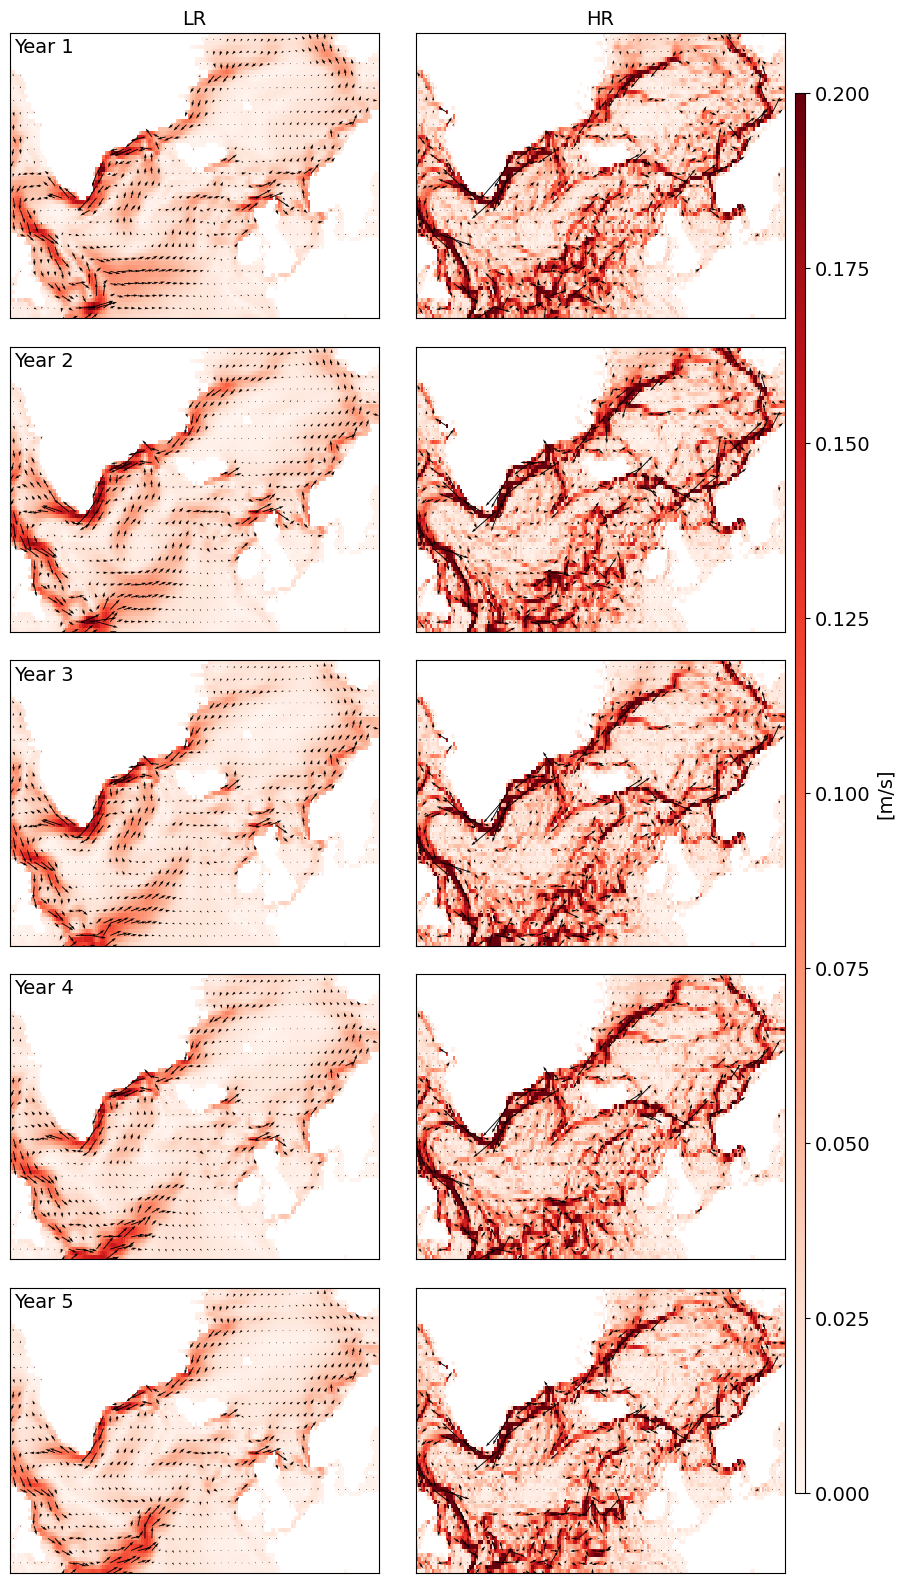

In [101]:
# Plot 100 avg vector fields
vector_plots(100)

***

### Water mass transformation Decade 1

Water mass transformation reflects the change in circulation. At LR relative to HR, WMT in the Irminger Basin becomes lighter and WMT in the Iceland Basin becomes heavier. *See plots below*

In [102]:
def WMT_mean():
    """Plot time-averaged WMT
    """

    # Plot 1D water mass transformation
    regionNames = ['Labrador Sea', 'Irminger Sea', 'Iceland Basin', 'Nordic Seas']
    fig, axs = plt.subplots(3, 1, figsize=(10, 10), gridspec_kw={'hspace': 0.1})
    palette = plt.get_cmap('tab10').colors
    xlim, ylim = [27, 28.2], [-3.5, 9]

    for ax, ctgy in zip(axs, ['total', 'heat', 'salt']):
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_ylabel(f'{ctgy} [Sv]')
        if ctgy == 'salt':
            ax.set_xlabel('$\\sigma_{\\theta}$ [kg m$^{-3}$]')
        else:
            ax.xaxis.set_ticklabels('')
        for meshName, ls in zip(meshNames, [':', '-']):
            for regionName, color in zip(regionNames, palette):
                label = regionName if meshName == 'HR' else None
                wmt = ds[meshName]['WMT'][ctgy + 'Transformation'].sel(regionNames=regionName).mean(dim='time')
                sigma = wmt.sigmaBins
                ax.plot(sigma, wmt, color=color, ls=ls, label=label)
        for sigma in [27.37, 27.58]:
            ax.plot([sigma, sigma], ylim, 'k--')
    axs[0].set_title('WMT Decade 1')
    axs[2].legend()

**WMT Decade 1**
   - Lighter ($\sigma=27.37$): More Irminger Sea (LR) and more Iceland Basin (HR)
   - Heavier ($\sigma=27.58$): More Iceland Basin (LR) and more Irminger Sea (HR)
   - LR is dashed, HR is solid

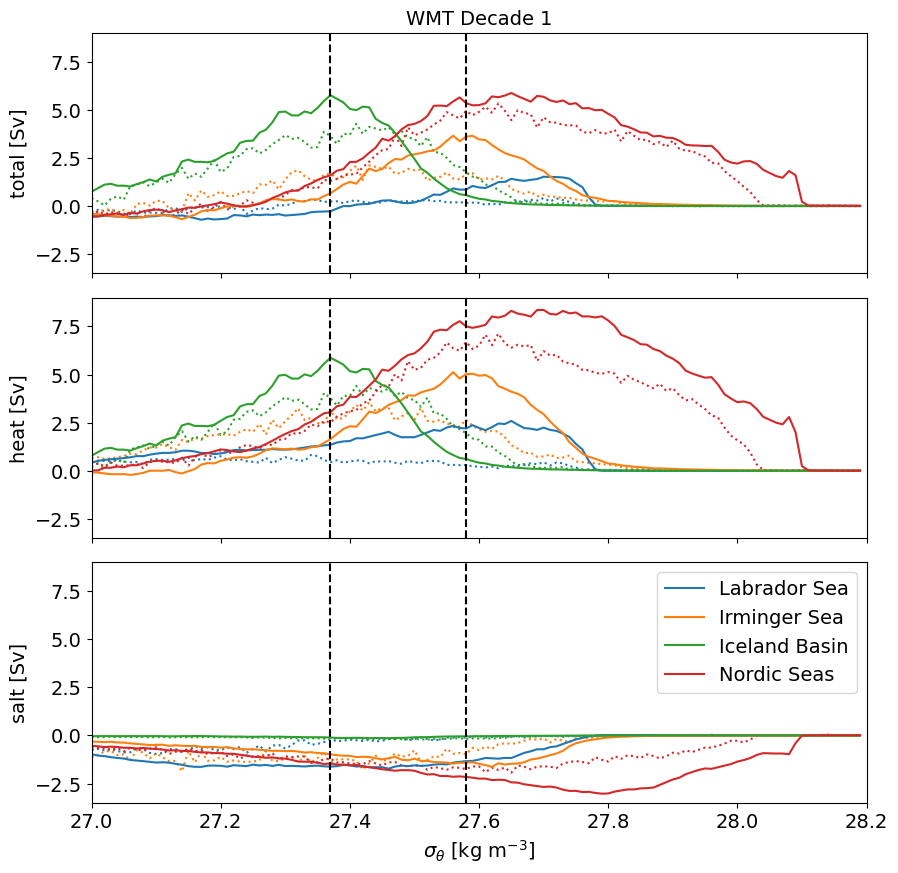

In [103]:
# Plot WMT
WMT_mean()

***

### Water mass transformation Hoffmueller plots

Adding the WMT time dimension, we can see the density drift of WMT in the Irminger Sea at LR over the first few years. *See plots below*

In [104]:
def WMT_hoffmueller(regionName):
    """Plot WMT as a Hoffmueller plot
    """

    # Plot 1D water mass transformation
    fig, axs = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw={'wspace': 0.1})

    for ax, meshName in zip(axs, meshNames):
        wmt = ds[meshName]['WMT']['totalTransformation'].sel(regionNames=regionName)
        times, sigma = wmt.time, wmt.sigmaBins
        c = ax.pcolormesh(sigma, times, wmt, vmin=-30, vmax=30, cmap='RdBu_r')
        ax.set_xlim([27, 27.8])
        ax.set_ylim(times[[0, -1]])
        ax.set_title(meshName)
        ax.set_xlabel('$\\sigma_{\\theta}$ [kg m$^{-3}$]')
        if meshName == 'LR':
            ax.text(0.99, 0.96, regionName, transform=ax.transAxes, ha='right')
        else:
            ax.yaxis.set_ticklabels('')
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(c, cax=cax, label='Sv')

**Irminger Sea** HR is stable but LR freshens over time.

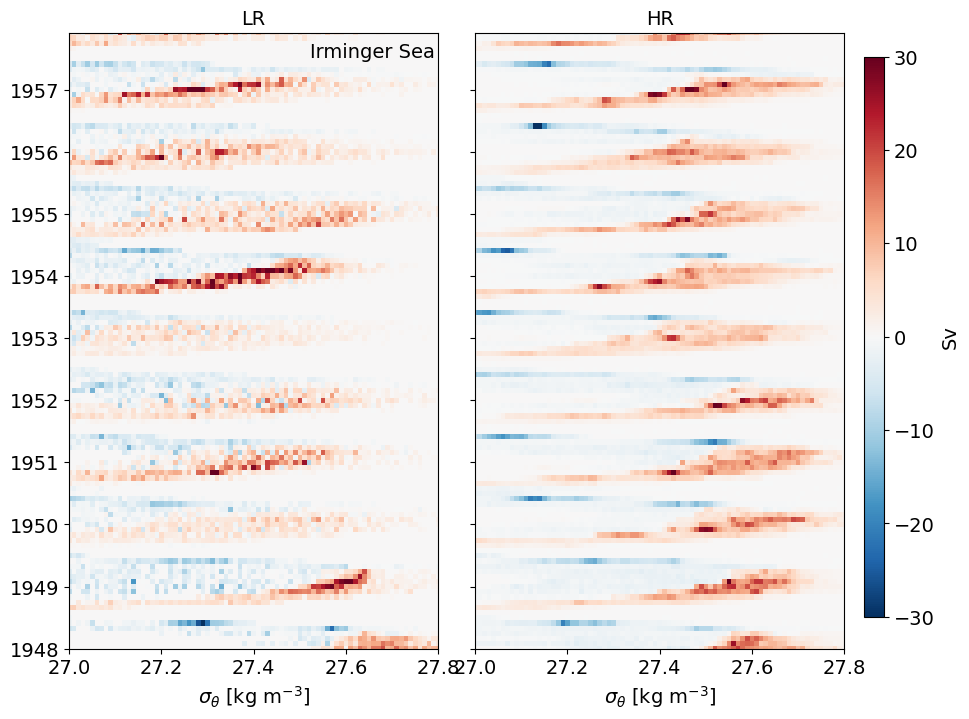

In [105]:
# Plot WMT Hoffueller Irminger Sea
WMT_hoffmueller('Irminger Sea')

**Iceland Basin** HR is stable but LR increases over time.

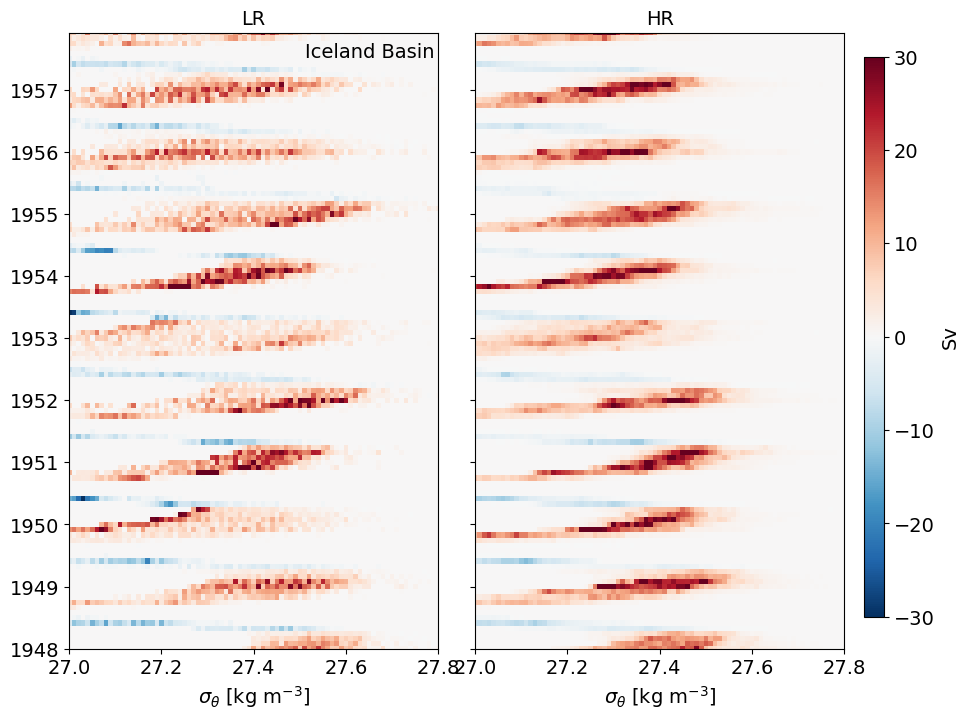

In [106]:
# Plot WMT Hoffueller Iceland Basin
WMT_hoffmueller('Iceland Basin')

***

### Water mass transformation 2D

In the 2D WMT fields, we see more Irminger Basin WMT on the lighter density surface at LR. On the heavier density surface, LR WMT has moved into the Iceland Basin, but HR WMT has spread out into the Irminger, Labrador and Norwegian Seas. *See plots below*

In [92]:
def plot_2D_transformation(sigmaBin):
    """Plot 2D transformation on the sigmaBin
    """

    # Make figure
    fig, axs = plt.subplots(3, 3, figsize=(10, 10), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
    xlim, ylim = [-70, 20], [40, 80]

    # Loop through rows and transformation categories
    for row, ctgy in zip(axs, ['total', 'heat', 'salt']):
        row[0].set_ylabel(ctgy + ' transformation')

        # Loop through panels and meshes
        residual = []
        for ax, meshName in zip(row, meshNames):

            # Plot transformation averaged over first 12 months of simulation on sigmaBin
            z = ds[meshName]['2D'][ctgy + 'Transformation'].sel(sigmaBins=sigmaBin).mean(dim='time')
            x, y = z.lon, z.lat
            c1 = ax.pcolormesh(x, y, z, vmin=-20, vmax=20, cmap='BrBG_r')
            residual.append(z)

        # Plot residual
        residual = np.subtract(*residual[::-1])
        c2 = row[2].pcolormesh(x, y, residual, vmin=-20, vmax=20, cmap='RdBu_r')

    # Formatting
    pos = []
    for col, title in zip(axs.T, meshNames + ['HR-LR']):
        col[0].set_title(title)
        pos.append(col[2].get_position())
        for ax in col:
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])

    # Add colorbars
    cax1 = fig.add_axes([pos[0].x0, 0.08, pos[1].x1 - pos[0].x0, 0.01])
    cax2 = fig.add_axes([pos[2].x0, 0.08, pos[2].width, 0.01])
    fig.colorbar(c1, cax1, orientation='horizontal', label='Sv')
    fig.colorbar(c2, cax2, orientation='horizontal', label='Sv')

**Lighter surface ($\sigma=27.37$)** More WMT in Irminger Sea at LR, more WMT in Iceland Basin at HR.

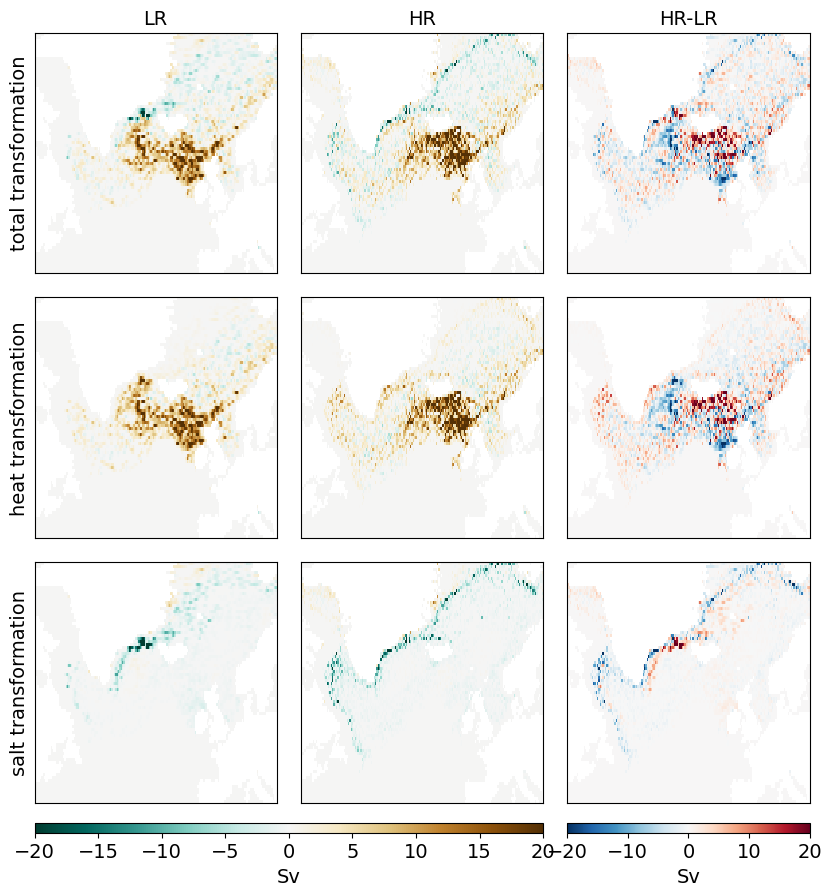

In [93]:
# Plot 2D transformation on sigma 27.37
plot_2D_transformation(27.37)

**Heavier surface ($\sigma=27.58$)** More WMT in Iceland Basin at LR, more WMT in Irminger, Labrador and Norwegian Seas at HR.

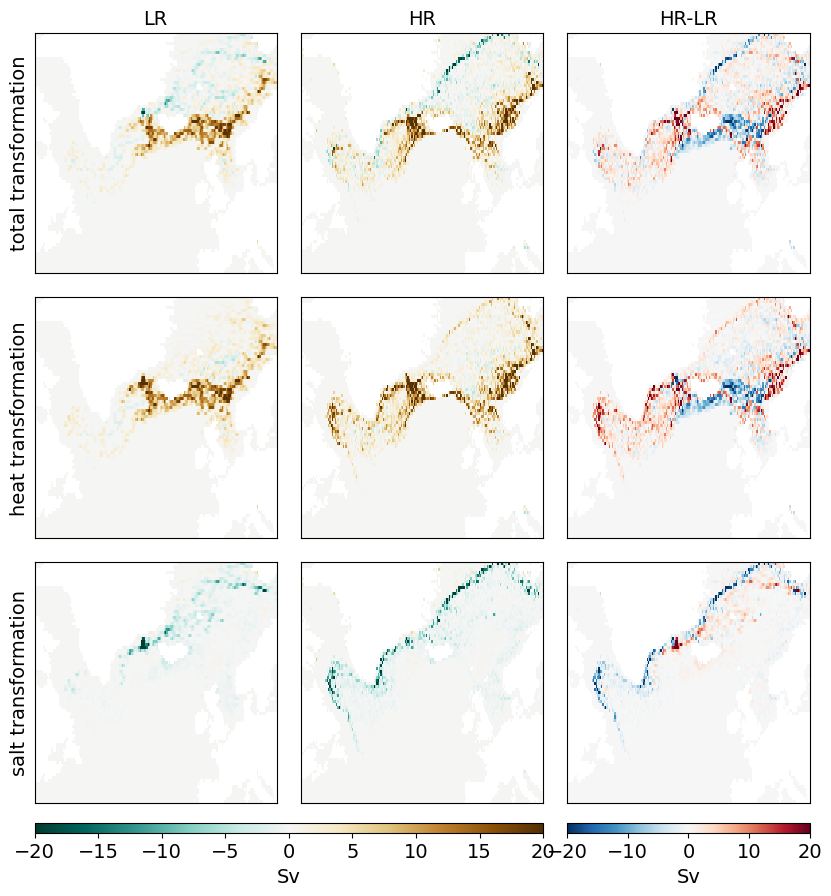

In [95]:
# Plot 2D transformation on sigma 27.58
plot_2D_transformation(27.58)

***

### Transect transports in $\sigma$-space

OSNAP East transport in both layers becomes lighter at LR within the first few years. *See plots below*

In [479]:
# Get coords again
coords, transectMasks = {}, {}
for meshName in meshNames:
    coords[meshName], transectMasks[meshName], _ = pptools.load_coords(meshName)

# Sigma bins
binsize = 0.01
sigmaBins = np.arange(27, 28.21, binsize)

In [142]:
def transport_sigma():
    """Plot transport in sigma space
    """
    
    transectNames = ['OSNAP East', 'Denmark Strait', 'Iceland-Faroe Ridge', 'Fram Strait', 'Barents Sea']

    # Plot transport
    fig, axs = plt.subplots(5, 2, figsize=(10, 14), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

    for row, transectName in zip(axs, transectNames):
        
        for ax, meshName in zip(row, meshNames):

            # Get transport variables
            names = list(ds[meshName]['transect'])
            sigma, dz, v = [ds[meshName]['transect'][name].sel(transectName=transectName) for name in names]
            times, edges = v.time, v.iEdge.values
            idx = edges > 0
            edges, sigma, dz, v = edges[idx], sigma[:, idx, :], dz[:, idx, :], v[:, idx, :]
            sigma = sigma - 1000
            transport = v * dz * coords[meshName]['dvEdge'][None, edges, None] * 1e-6

            # Get transport in density space
            transportSigma = []
            for sigmaBin in sigmaBins:
                sigmaMask = (sigma >= sigmaBin) & (sigma <= sigmaBin + binsize)
                transportSigma.append(np.ma.masked_where(~sigmaMask, transport).sum(axis=(1, 2)).data)
            transportSigma = np.vstack(transportSigma).T

            # Plot
            c = ax.pcolormesh(sigmaBins, times, transportSigma, vmin=-2, vmax=2, cmap='RdBu')
            ax.set_xlim([27, 28.1])
            if transectName == 'OSNAP East':
                ax.set_title(meshName)
            if transectName == 'Barents Sea':
                ax.set_xlabel('$\\sigma_{\\theta}$ [kg m$^{-3}$]')
            else:
                ax.xaxis.set_ticklabels('')
            if meshName == 'LR':
                ax.text(0.01, 0.9, transectName, transform=ax.transAxes)
            else:
                ax.yaxis.set_ticklabels('')

    cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    fig.colorbar(c, cax=cax, label='Sv')

**Transport vs $\sigma$**
   - **OSNAP East** Drift to lighter at LR
   - **Denmark Strait** Small, delayed drift to lighter export at LR
   - **Iceland-Faroe Ridge** Drift to lighter import at HR
   - **Fram Strait** Reduced transport at LR
   - **Barents Sea** Weak overall transport in both LR and HR

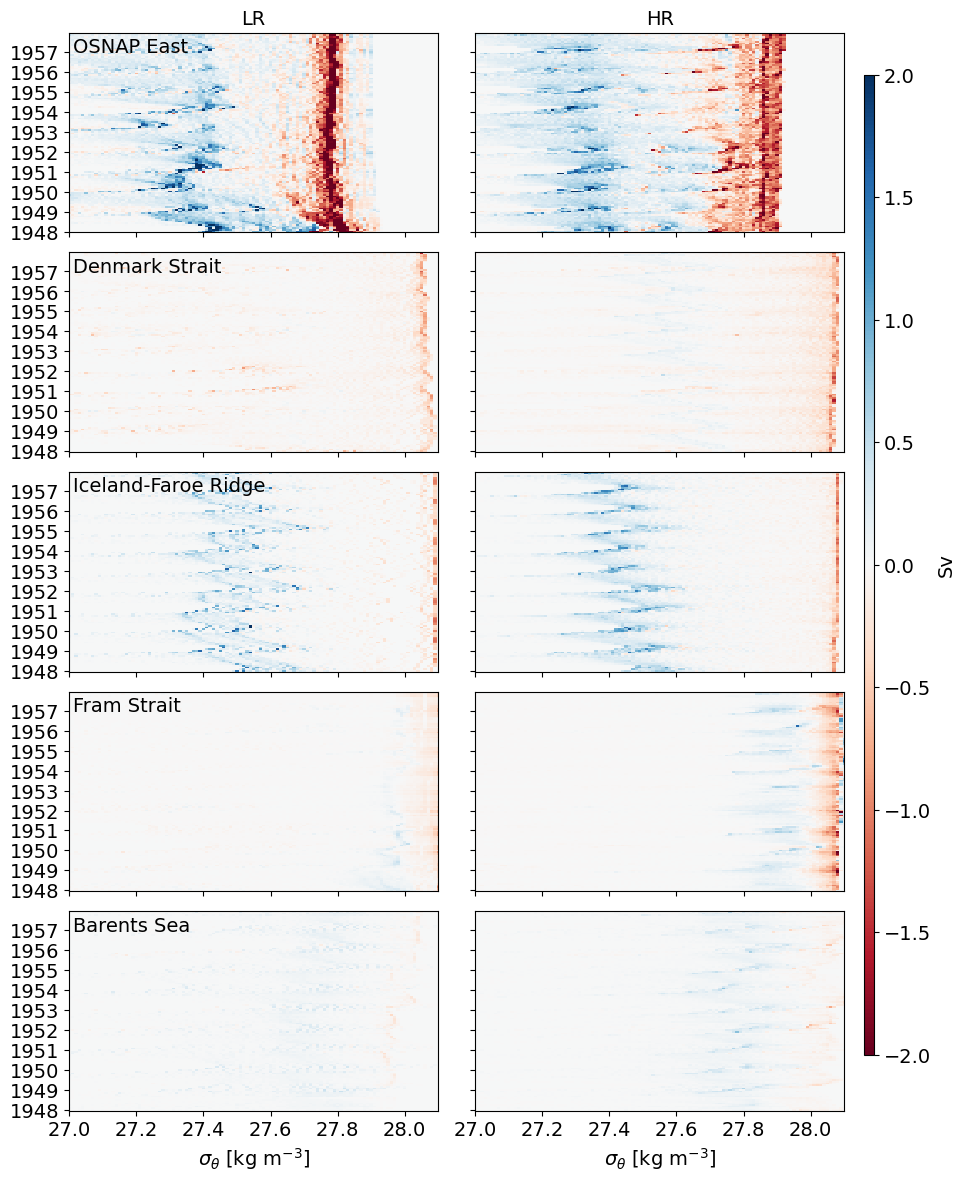

In [143]:
# Plot transport at OSNAP East
transport_sigma()

***

### Transect transports

Description. *See plots below*

In [507]:
def transport_section(transectName, sigmalevels, lims, clim):
    """
    """

    # Plot OSNAP East transport
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'hspace': 0.05})

    for ax, meshName in zip(axs, meshNames):

        # Get transport variables
        names = list(ds[meshName]['transect'])
        sigma, dz, v = [ds[meshName]['transect'][name].sel(transectName=transectName) for name in names]
        edges, distance = v.iEdge.values, v.distance.values
        idx = edges > 0
        distance = distance[idx]
        sigma, v = [var[:, idx, :].mean(dim='time') for var in (sigma, v)]
        sigma, distance = sigma - 1000, distance * 1e-3

        # Mean and mask
        bottom_mask = v == 0
        sigma, v = [np.ma.masked_where(bottom_mask, var).T for var in (sigma, v)]
        
        # Plot
        linestyles = ['-', ':', '--', '-.']
        c = ax.pcolormesh(
            distance, coords[meshName]['refBottomDepth'], v,
            vmin=-clim, vmax=clim, cmap='RdBu',
        )
        cs = ax.contour(
            distance, coords[meshName]['refBottomDepth'], sigma,
            levels=sigmalevels, colors='k', linestyles=linestyles,
        )
        ax.set_facecolor('gray')
        ax.set_xlim(lims[:2])
        ax.set_ylim(lims[2:])
        ax.set_ylabel('Depth [m]')
        for sigmalevel, ls in zip(sigmalevels, linestyles):
            ax.plot(0, 0, 'k', ls=ls, label=sigmalevel)

    axs[1].set_xlabel('Along-transect distance [km]')
    axs[0].xaxis.set_ticklabels('')
    cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    fig.colorbar(c, cax=cax, label='m/s')
    axs[0].legend(loc=4)

def vector_plots():
    """Plot vector fields averaged to 1000
    """
    
    transectNames = ['OSNAP East', 'Denmark Strait', 'Iceland-Faroe Ridge', 'Fram Strait', 'Barents Sea']

    # Plot 100 m avg velocities
    fig, axs = plt.subplots(2, 1, figsize=(10, 12), gridspec_kw={'hspace': 0.1})
    for meshName, ax, scale in zip(meshNames, axs, [1, 3]):
        
        # Plot velocity
        ax.set_title(meshName)
        names = ['velocityZonal', 'velocityMeridional']
        u, v = [ds[meshName]['2D'][name].sel(depth=1000).mean(dim='time') for name in names]
        lon, lat = u.lon, u.lat
        spd = np.sqrt(u**2 + v**2)
        c = ax.pcolormesh(lon, lat, spd, vmin=0, vmax=0.2, cmap='Reds')
        q = ax.quiver(lon[::3], lat[::3], u[::3, ::3], v[::3, ::3], scale=scale)
        
        # Plot transects
        for transectName in transectNames:
            edges = transectMasks[meshName][transectName]['edges']
            lon, lat = [coords[meshName][name][edges] for name in ('lonEdge', 'latEdge')]
            ax.plot(lon, lat, '-', color='magenta', lw=2)
        
        # Formatting
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.set_xlim(-50, 20)
        ax.set_ylim(50, 80)
        ax.set_facecolor('gray')
    cax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
    fig.colorbar(c, cax=cax, label='[m/s]')

**Velocity 1000 m average (decade 1)**

For reference for the following transport sections. *See plots below*

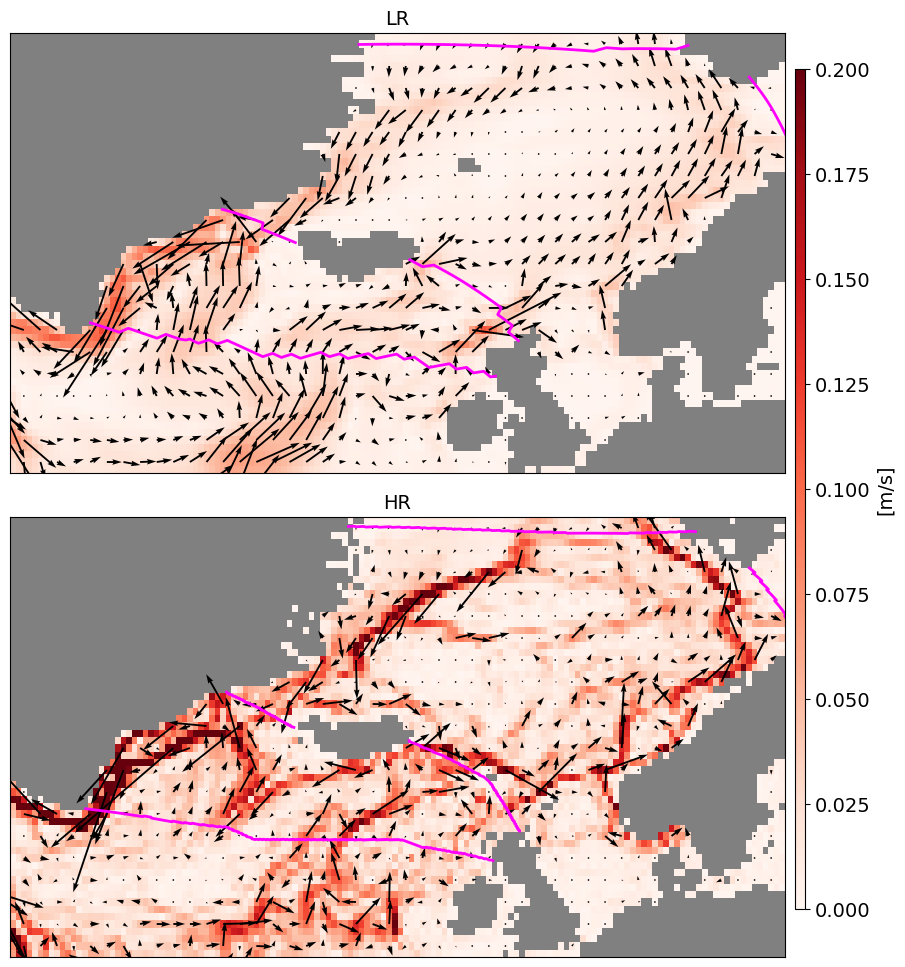

In [509]:
# Plot 1000 m velocities
vector_plots()

**OSNAP East**

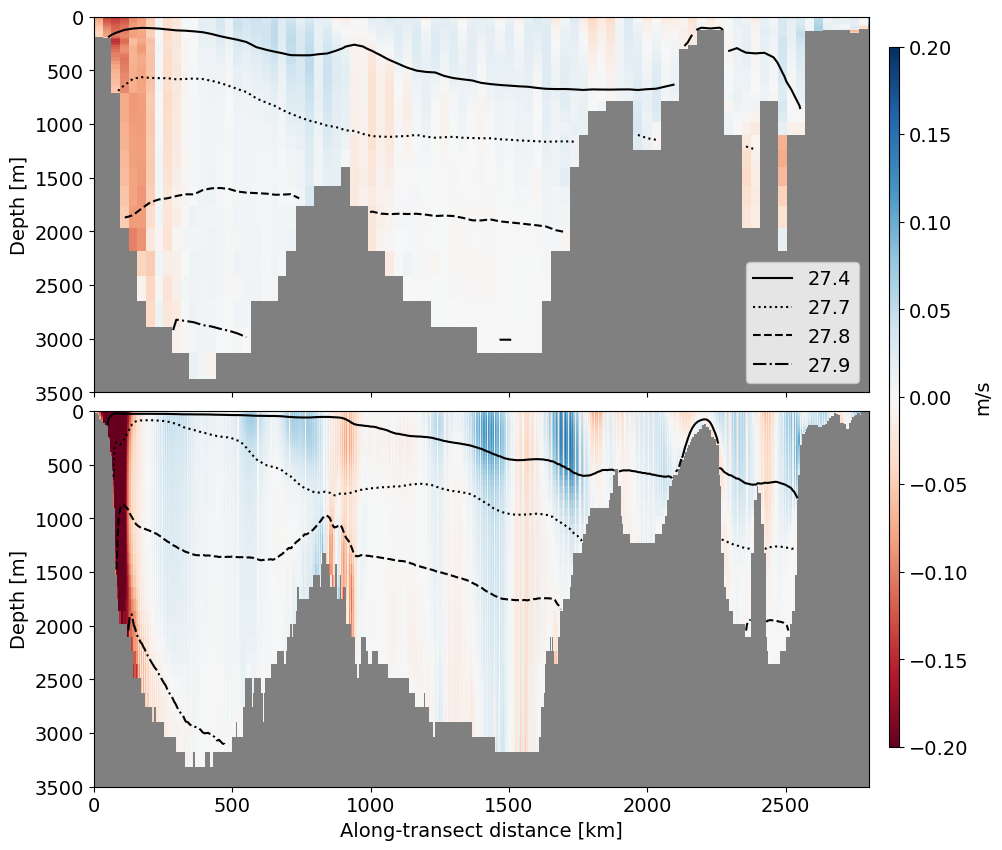

In [390]:
# Plot OSNAP East transect
sigmalevels, lims, clim = [27.4, 27.7, 27.8, 27.9], [0, 2800, 3500, 0], 0.2
transport_section('OSNAP East', sigmalevels, lims, clim)

**Denmark Strait**

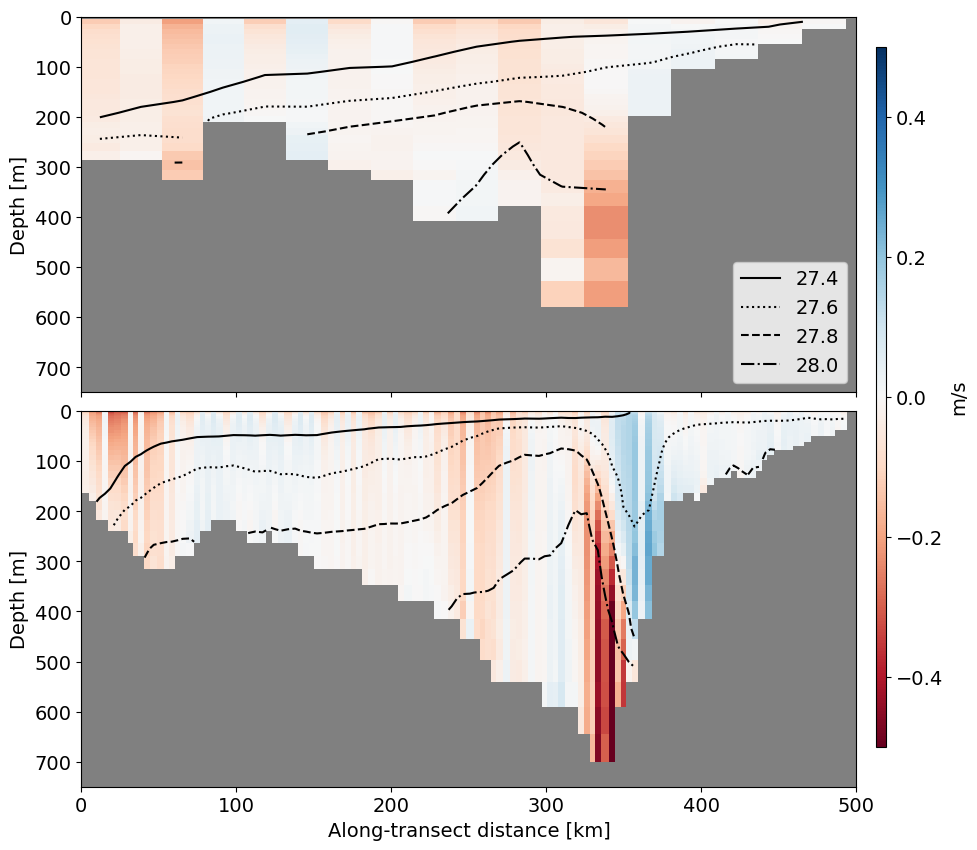

In [391]:
# Plot Denmark Strait transect
sigmalevels, lims, clim = [27.4, 27.6, 27.8, 28.0], [0, 500, 750, 0], 0.5
transport_section('Denmark Strait', sigmalevels, lims, clim)

**Iceland-Faroe Ridge**

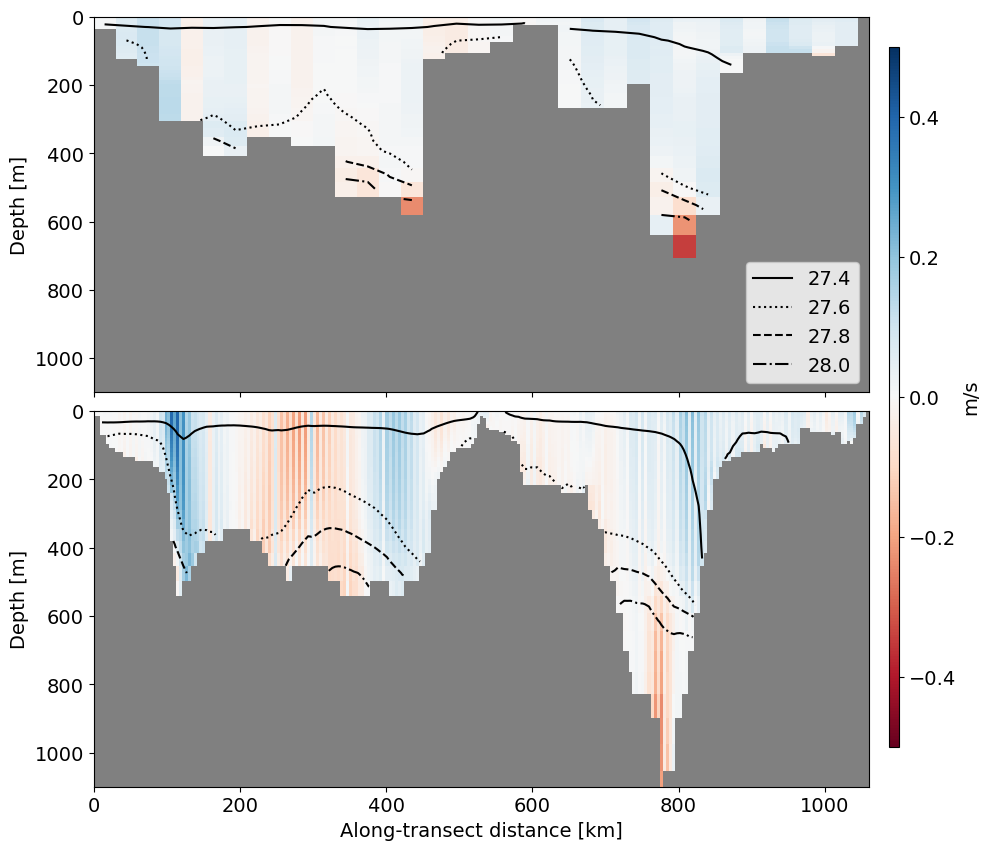

In [405]:
# Plot Iceland-Faroe Ridge transect
sigmalevels, lims, clim = [27.4, 27.6, 27.8, 28.0], [0, 1060, 1100, 0], 0.5
transport_section('Iceland-Faroe Ridge', sigmalevels, lims, clim)

**Fram Strait**

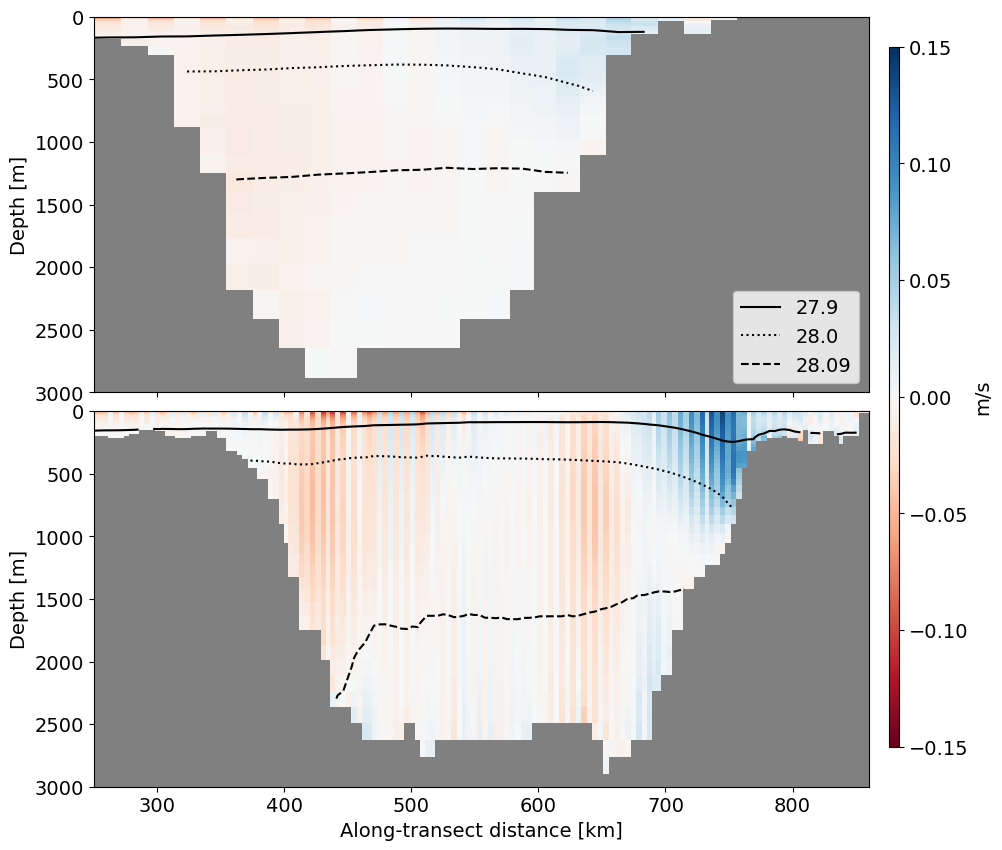

In [435]:
# Plot Fram Strait transect
sigmalevels, lims, clim = [27.9, 28.0, 28.09], [250, 860, 3000, 0], 0.15
transport_section('Fram Strait', sigmalevels, lims, clim)

**Barents Sea**

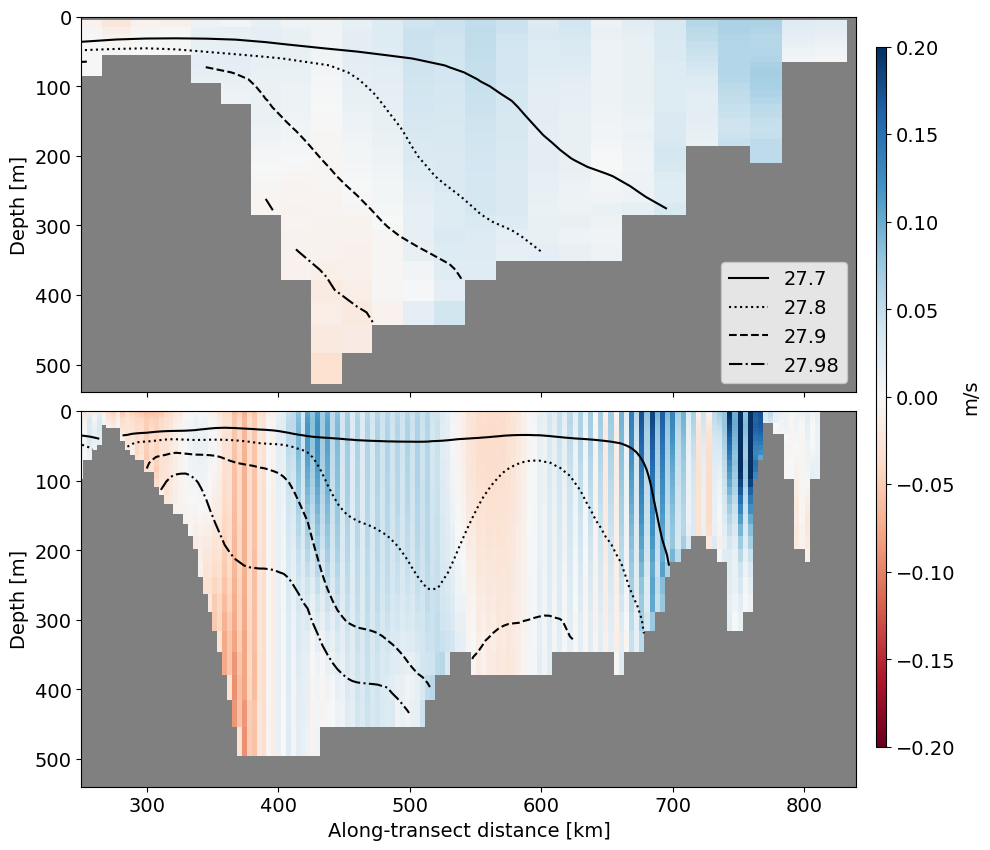

In [452]:
# Plot Barents Sea transect
sigmalevels, lims, clim = [27.7, 27.8, 27.9, 27.98], [250, 840, 540, 0], 0.2
transport_section('Barents Sea', sigmalevels, lims, clim)